# Download de Série Temporal de Satélite utilizando GEE api em Python a partir de shapefile

Criação: Sabrina Paes Leme (paeslemesa@gmail.com) <br>
Data de criação: 28/03/2024 <br>

É necessário ter conta no __Google Earth Engine__ (GEE) para dar prosseguimento!

In [8]:
#Caso não tenha a biblioteca instalada, descomente a linha abaixo
#!pip install ee geemap pycrs

## 1. Importando bibliotecas

In [58]:
# 1. Bibliotecas relacionadas ao GEE
import ee # Biblioiteca Earth Engine
import geemap # Biblioteca Geemap

# 2. Bibliotecas auxiliares
import geopandas as gpd # Biblioteca de manipulação de dados geoespaciais
import numpy as np # Biblioteca de manipulação de arrays
from shapely.geometry import Polygon # Biblioteca de manipulação de geometrias
import rasterio # Biblioteca de manipulação de imagens raster
import os # Biblioteca de manipulação de arquivos
import  glob # Biblioteca de manipulação de arquivos
import requests # Biblioteca de requisições HTTP
import zipfile # Biblioteca de manipulação de arquivos zip



In [3]:
# 3. Autenticação no GEE
ee.Authenticate()

# 4. Inicialização do GEE
ee.Initialize()

## 2. Determinando as entradas

Aqui nós vamos inserir o caminho do nosso shapefile de entrada e as datas que queremos trabalhar.

Observação: o shapefile de entrada deve estar no sistema __EPSG:4326__

In [11]:
cam_shp = "D:/Pesquisa/Artigo_Mestrado/00_Dados/AOI.shp" # Caminho do shapefile inteiro (polígono)

data_ini = "2023-01-01" # Data de início da série temporal em formato "YYYY-MM-DD"
data_fim = "2024-03-30" # Data de fim da série temporal em formato "YYYY-MM-DD"

perce_nuvens = 20 # Porcentagem de nuvens máxima aceitável


cam_saida = r"D:/Pesquisa/Artigo_Mestrado/01_Imagens/Sentinel2" # Caminho de saída das imagens
bandas = ["B2", # Azul
          "B3", # Verde
          "B4", # Vermelho
          "B8"] # Infravermelho próximo

### 2.1. Lendo o shapefile

In [5]:
geom = geemap.shp_to_ee(cam_shp) # Função para converter shapefile em geometria do GEE

# Abrindo a geometria em forma ee. Nesse caso, podemos perceber
#geom

## 3. Acessando ao catálogo de imagens do GEE

Neste caso, usaremos imagens Bottom-Of-Atmosphere (BOA) do Sentinel-2. <br>
A referência para acessar este catálogo está em: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED#colab-python


In [6]:
# Adicionando função de máscara de nuvens (código do GEE)
# Esta função serve como exemplo de como aplicar função do GEE no Python API
def mask_s2_clouds(image):
    """ Mascara nuvens do Sentinel-2 usando banda QA.
    Args:
        image (ee.Image): Uma imagens do Sentinel-2.
    Returns:
        ee.Image: Uma imagem com máscara aplicada do Sentinel-2.
    """
    qa = image.select('QA60')

    # Bits 10 e 11 são nuvens e cirrus, respectivamente.
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11

    # Ambos os bits devem ser definidos como zero, indicando condições claras.
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )

    return image.updateMask(mask).divide(10000) # quando aplicamos essa máscara, dividimos por 10000 para normalizar os valores do Sentinel-2

In [12]:
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') # Carregando a coleção de imagens Sentinel-2
    .filterDate(data_ini, data_fim) # Filtrando por data
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', perce_nuvens))  # Filtrando por porcentagem de nuvens
    .filterBounds(geom) # Filtrando pela nossa área de interesse
    .map(mask_s2_clouds) # aplicando a máscara e normalizando os valores do Sentinel-2
)

#dataset

### 3.1. Visualizando os dados

Neste caso, estamos calculando a mediana entre todas as imagens de entrada.<br>
Devemos transformar o catálogo em uma única imagem, para isto, outras opções são:
* Selecionar a primeira imagem com <code>dataset.first()</code>
* Calcular o mosaico das imagens com <code>dataset.mosaic()</code>
* Calcular a média das imagens com <code>dataset.mean()</code>

In [13]:
visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B4', 'B3', 'B2'], # escolhendo trabalhar com RGB
}

m = geemap.Map()
m.centerObject(geom, 13)
m.add_layer(dataset.median().clip(geom), visualization, 'RGB')
m.addLayer(geom, {}, 'Área de Interesse')
m

Map(center=[-3.6521489312356517, -52.5171171175822], controls=(WidgetControl(options=['position', 'transparent…

Você deve ver alguma coisa parecida com isso:

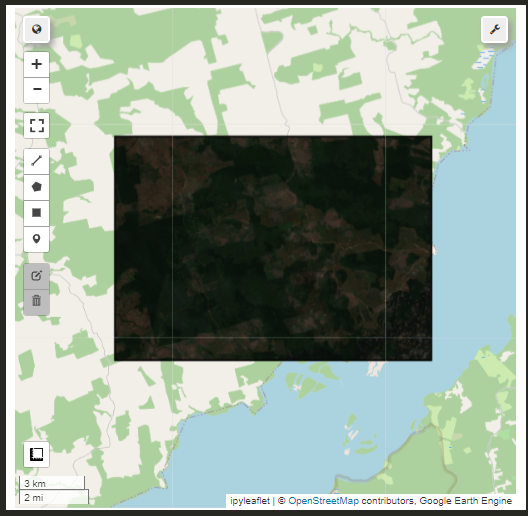

## 4. Configurando o download
Nesse primeiro momentos, vamos baixar todas as imagens que estão disponíveis no período de tempo que determinamos. <br>
E cada imagem terá como nome da sua data de aquisição

<span style="color:gray">Não se preocupe, no próximo algoritmo, vamos trabalhar com média/mediana mensal, tá bem? text</span>


### 4.1. Selecionando as bandas e acessando metadados da ImageCollection

In [14]:
dataset = dataset.select(bandas) # Selecionando as bandas de interesse

# O que saiu disso aí? Aqui está comentado para que o turial fique menor, mas recomendo que futuque bastante :D
#dataset

Para a minha pesquisa, conseguimos ver que há 28 imagens disponíveis na área de interesse, já com as nossas bandas filtradas.

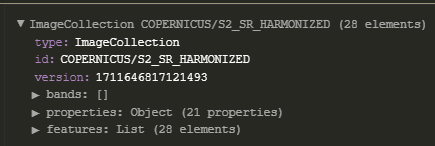

Se formos olhar as feições, conseguimos ver as todos os metadados de cada imagem. Para acessar e utilizar a esse metadados como um dicionário (JSON), basta usar o comando <code>dataset.getInfo()</code>



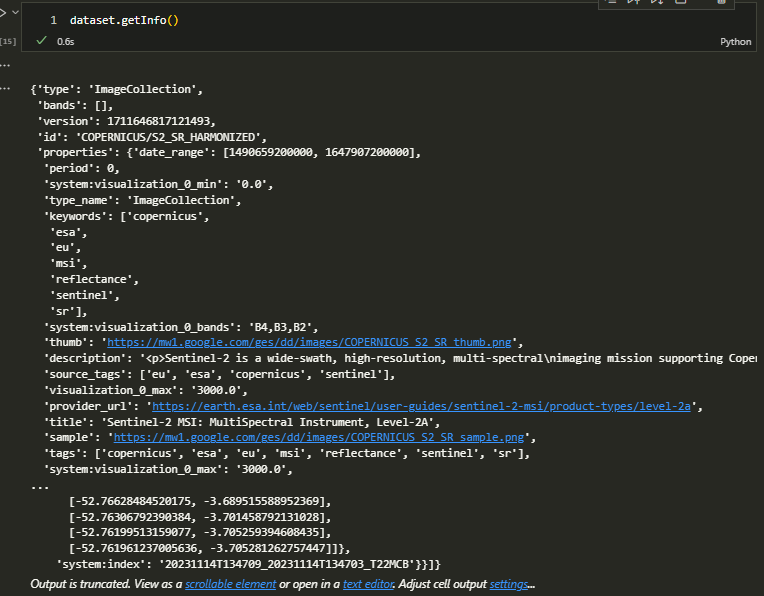

In [17]:
#dataset.getInfo()

### 4.2. Determinando as coordenadas para filtrar o download

Existem duas formas de se fazer isso:
* Usando o GeoPandas -> eu recomendo porque acredito que rode bem mais rápido
* Usando o <code>geom.getInfo()</code> -> pode ser útil, mas pode variar para cada tipo de shapefile e pode dar erros. Eu recomendo desbravar.

Para fazer com o <code>geom.getInfo()</code>, precisamos ir "procurando" a ordem correta para cada shapefile.

Para o caso da minha área de interesse, o código está abaixo. Mas vale a pena explorar.

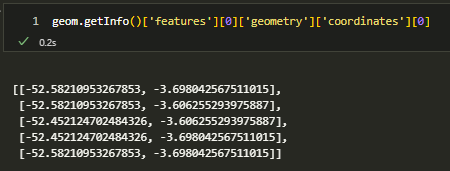

In [37]:
#geom.getInfo()['features'][0]['geometry']['coordinates'][0]

Já para encontrar as coordinadas usando o geopandas, basta usar o código abaixo.

Este código já vai pegar os valores de <code>Xmin</code>, <code>Xmax</code>, <code>Ymin</code>, <code>Ymax</code> de cada feição. Estamos aqui selecionando a primeira (valor 0).

In [39]:
gdf = gpd.read_file(cam_shp) # Lendo o shapefile
coords = gdf.geometry.bounds.values[0] # Pegando as coordenadas do shapefile

bbox = [[coords[0], coords[1]],
        [coords[0], coords[3]],
        [coords[2], coords[3]],
        [coords[2], coords[1]],
        [coords[0], coords[1]]]   

bbox

[[-52.58210953267853, -3.698042567511015],
 [-52.58210953267853, -3.606255293975887],
 [-52.452124702484326, -3.606255293975887],
 [-52.452124702484326, -3.698042567511015],
 [-52.58210953267853, -3.698042567511015]]

Neste momento, estamos determinando as configurações de download que usaremos

## 5. Baixando a série temporal

Diferente de baixar uma única imagem, aqui nós usaremos um loop para cada imagem. E para cada imagem faremos uma requisição (request) de download.

Como será uma requisição diferente, para cada imagem, faremos uma configuração de tarefa diferente também.

Primeiro vamos definir a lista das imagens que vamos trabalhar. Um trechinho dela está aqui embaixo.
Vale a pena explorar bastante essas informações para nos adaptarmos a utilização de dicionários e à forma que o GEE funciona.

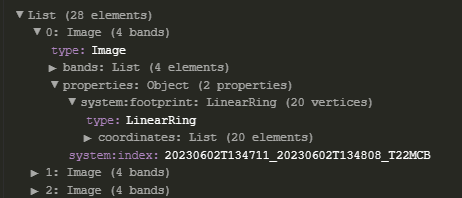

In [55]:
image_ids = dataset.toList(dataset.size()) # Esse comando vai criar um dicionário com os IDs das imagens

#image_ids

In [59]:
for j, imagem_id in enumerate(image_ids.getInfo()): # Loop para exportar as imagens

    #---------------------------------------------------------------------------------------
    # 1. Definindo a tarefa de exportação
    #---------------------------------------------------------------------------------------
    imagem = (ee.Image(image_ids.get(j))) # acessando a imagem

    configuracao_tarefa = {"image" : imagem, # Imagem que será exportada
                        "description" : "Sentinel2", # uma descrição qualquer
                        "region" : bbox, # Bounding Box da área de interesse
                        "scale" : 10, # resolucao em metros
                        "crs": 'EPSG:4326', # CRS de saída, pode alterar aqui para o CRS desejado
                        "fileNamePrefix": imagem.id().getInfo() + str(j), # Prefixo do nome do arquivo
                        "fileFormat" : "GeoTIFF", # Formato do raster de saída
                        }


    nome_zip = os.path.join(cam_saida, f"Sentinel2_{imagem.id().getInfo()}.zip") # Nome do arquivo zipado de saída

    download_url = imagem.getDownloadURL(configuracao_tarefa)  # Pegando a URL de download

    resposta = requests.get(download_url) # Fazendo a requisição da URL

    #---------------------------------------------------------------------------------------
    # 2. Bailando arquivo ZIP
    #---------------------------------------------------------------------------------------

    with open(nome_zip, 'wb') as f: # Escrevendo o arquivo zipado
        f.write(resposta.content)

    # Agora você deve ter um arquivo zipado com a imagem que você solicitou no caminho de saída que você definiu
        
    # Este código abaixo descompacta o arquivo zipado
    with zipfile.ZipFile(nome_zip, 'r') as zip_file: # Abrindo o arquivo zipado
        zip_file.extractall(cam_saida)  # Extraindo o arquivo zipado        

    #---------------------------------------------------------------------------------------
    # 3. Concatenando as bandas
    #---------------------------------------------------------------------------------------
    # Em primeiro momento, devemos definir o nome do arquivo de saída
    arquivo_saida = os.path.join(cam_saida, f"Sentinel2_{imagem.id().getInfo()}.tif")

    # Agora vamos encontrar os tifs exportados do ZIP
    lista_imgs = glob.glob(os.path.join(cam_saida, "*.tif")) # Lista de arquivos tif no caminho de saída


    # Agora vamos criar um loop para abrir os arquivos tif e concatenar as bandas
    for i, arquivo in enumerate(lista_imgs): # Loop para abrir os arquivos TIF
        if i == 0:
            # Para a primeira imagem, vamos abrir o arquivo e pegar as informações de perfil
            with rasterio.open(arquivo) as src:
                perfil = src.profile # pegando informações de coordenadas e metadados da imagem
                img = src.read(1) # lendo a primeira banda
                img = img[np.newaxis,:,:] # adicionando uma dimensão ao array para concatenar as outras bandas
        else:
            # Para as demais imagens, vamos abrir o arquivo e concatenar as bandas
            with rasterio.open(arquivo) as src:
                img = np.concatenate((img, src.read(1)[np.newaxis,:,:]), axis=0) # concatenando as bandas


    # Como pegamos os metadados apenas de uma banda, precisamos atualizar o perfil com as informações de todas as bandas
    perfil.update({"count": img.shape[0]})

    # Agora vamos escrever o arquivo de saída
    with rasterio.open(arquivo_saida, 'w', **perfil) as dst: # Escrevendo o arquivo de saída
        dst.write(img) # Escrevendo as bandas    

    print("Imagem salva como: ", arquivo_saida.split("\\")[-1]) # Printando o caminho de saída da imagem


Imagem salva como:  Sentinel2_20230602T134711_20230602T134808_T22MCB.tif
Imagem salva como:  Sentinel2_20230622T134711_20230622T134757_T22MCA.tif
Imagem salva como:  Sentinel2_20230622T134711_20230622T134757_T22MCB.tif
Imagem salva como:  Sentinel2_20230625T135711_20230625T135742_T22MCA.tif
Imagem salva como:  Sentinel2_20230625T135711_20230625T135742_T22MCB.tif
Imagem salva como:  Sentinel2_20230627T134709_20230627T135117_T22MCA.tif
Imagem salva como:  Sentinel2_20230627T134709_20230627T135117_T22MCB.tif
Imagem salva como:  Sentinel2_20230707T134709_20230707T135100_T22MCA.tif
Imagem salva como:  Sentinel2_20230707T134709_20230707T135100_T22MCB.tif
Imagem salva como:  Sentinel2_20230722T134711_20230722T134921_T22MCA.tif
Imagem salva como:  Sentinel2_20230722T134711_20230722T134921_T22MCB.tif
Imagem salva como:  Sentinel2_20230725T135711_20230725T135707_T22MCA.tif
Imagem salva como:  Sentinel2_20230725T135711_20230725T135707_T22MCB.tif
Imagem salva como:  Sentinel2_20230804T135711_20230